# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

In this example, we examine the impact of upscaling the well using
- the assumption that the well is a solid rod of steel
- averaging conductivity such that the $\sigma A$ is the same in both cases

These experiments are conducted at DC. The initial model we consider is based on that shown Um, 2015, *Finite element modelling of transient electromagnetic fields near steel-cased wells* https://doi.org/10.1093/gji/ggv193 

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [36]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In the first example, the well is 200m long. The thickness of the casing is 12mm. Here, we are interested in examining a top casing source, where one electrode is connected to the top of the casing and a return electrode is some radial distance away on the surface. In the following examples, we will put the return electrode a distance of 2x the length of the well (for the first example, it is 400 m away). For datam we measure the radial electric field along a line $90^\circ$ from the source wire, starting from the well and measuring out to a distance of 400m away. 

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [37]:
simDir = 'DC_approximations'  # create a simulation directory where results can be saved. 

In [38]:
# casing parameters by experiment 
experiments = {
    1: {'casing_l': 200, 'sigma_back': 1e-1},
    2: {'casing_l': 200, 'sigma_back': 1e-1},
    3: {'casing_l': 1000, 'sigma_back': 1e-2},
}

### select an experiment

In [39]:
experiment = 1

In [40]:
casing_l = experiments[experiment]['casing_l']
sigma_back = experiments[experiment]['sigma_back']

print(
    'Setting up experiment {}. \nThe casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        experiment, casing_l, sigma_back
    )
)

Setting up experiment 1. 
The casing is 200m long, and the conductivity of the background is 0.1 S/m


In [41]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

model = casingSim.model.CasingInHalfspace(
    directory = simDir,
    sigma_casing = 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 3e-7,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [42]:
# Here we print the parameters being used to set up the simulation
mdict = model.serialize()
mdict.pop('__class__')

'CasingInHalfspace'

In [43]:
model2 = casingSim.model.CasingInHalfspace(**mdict)
model2.serialize()

{'__class__': 'CasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 200.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_approximations',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 3e-07,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [400.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [54]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
ncy = 12
# nstretchy = 5
# stretchfact = 1.5
# hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = np.ones(ncy)
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


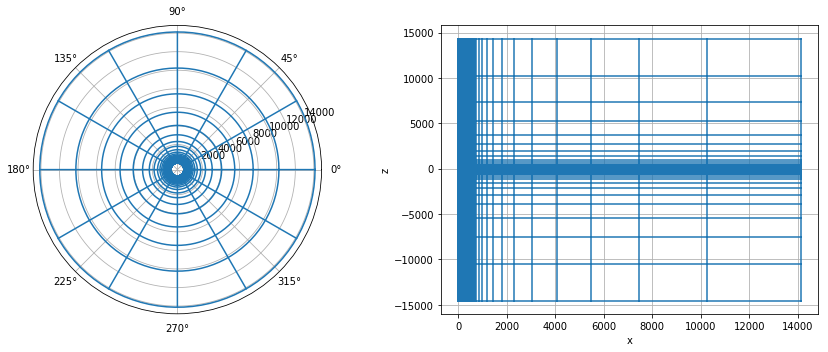

In [55]:
cylMeshGen.mesh.plotGrid()

In [64]:
src_theta = np.pi + hy[0]/2

model.src_a[1] = src_theta
model.src_b[1] = src_theta

for m in modelDict.values():
    m.src_a[1] = src_theta
    m.src_b[1] = src_theta

(0.0, 600.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


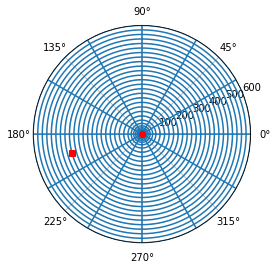

In [65]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

## Create models to compare to

Here, we create two more models which we want to simulate on
- `solid` fills in the center of the casing with a conductivity equal to that of steel
- `sigma_A` approximates the casing as a solid rod with conductivity found by preserving the conductivity - cross sectional area product. 

In [95]:
casing_d

0.1

In [105]:
model_solid.casing_r

0.045000000000000005

In [106]:
# Solid steel
model_solid = model.copy()
model_solid.casing_d = casing_d / 2.
model_solid.casing_t = casing_d / 2.
model_solid.sigma_inside = model_solid.sigma_casing  # fill in the center of the well with steel

In [109]:
# average so that we preserve the conductivity * cross sectional area
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2) / (model.casing_b**2)  # times pi / pi

model_sigma_A = model_solid.copy()
model_sigma_A.sigma_inside = sigmaA
model_sigma_A.sigma_casing = sigmaA

print("Preserving sigma * A gives a conductivity of {} S/m".format(sigmaA))

Preserving sigma * A gives a conductivity of 1799999.9999999993 S/m


In [110]:
# put the models in a dictionary for convienence 
model_names = ['baseline', 'solid', 'sigma_A']
modelDict = dict(zip(model_names, [model, model_solid, model_sigma_A]))

In [111]:
# Assign physical properties on the mesh
physpropsDict = {
    'baseline': casingSim.model.PhysicalProperties(cylMeshGen, model),
    'solid': casingSim.model.PhysicalProperties(cylMeshGen, model_solid),
    'sigma_A': casingSim.model.PhysicalProperties(cylMeshGen, model_sigma_A)
}

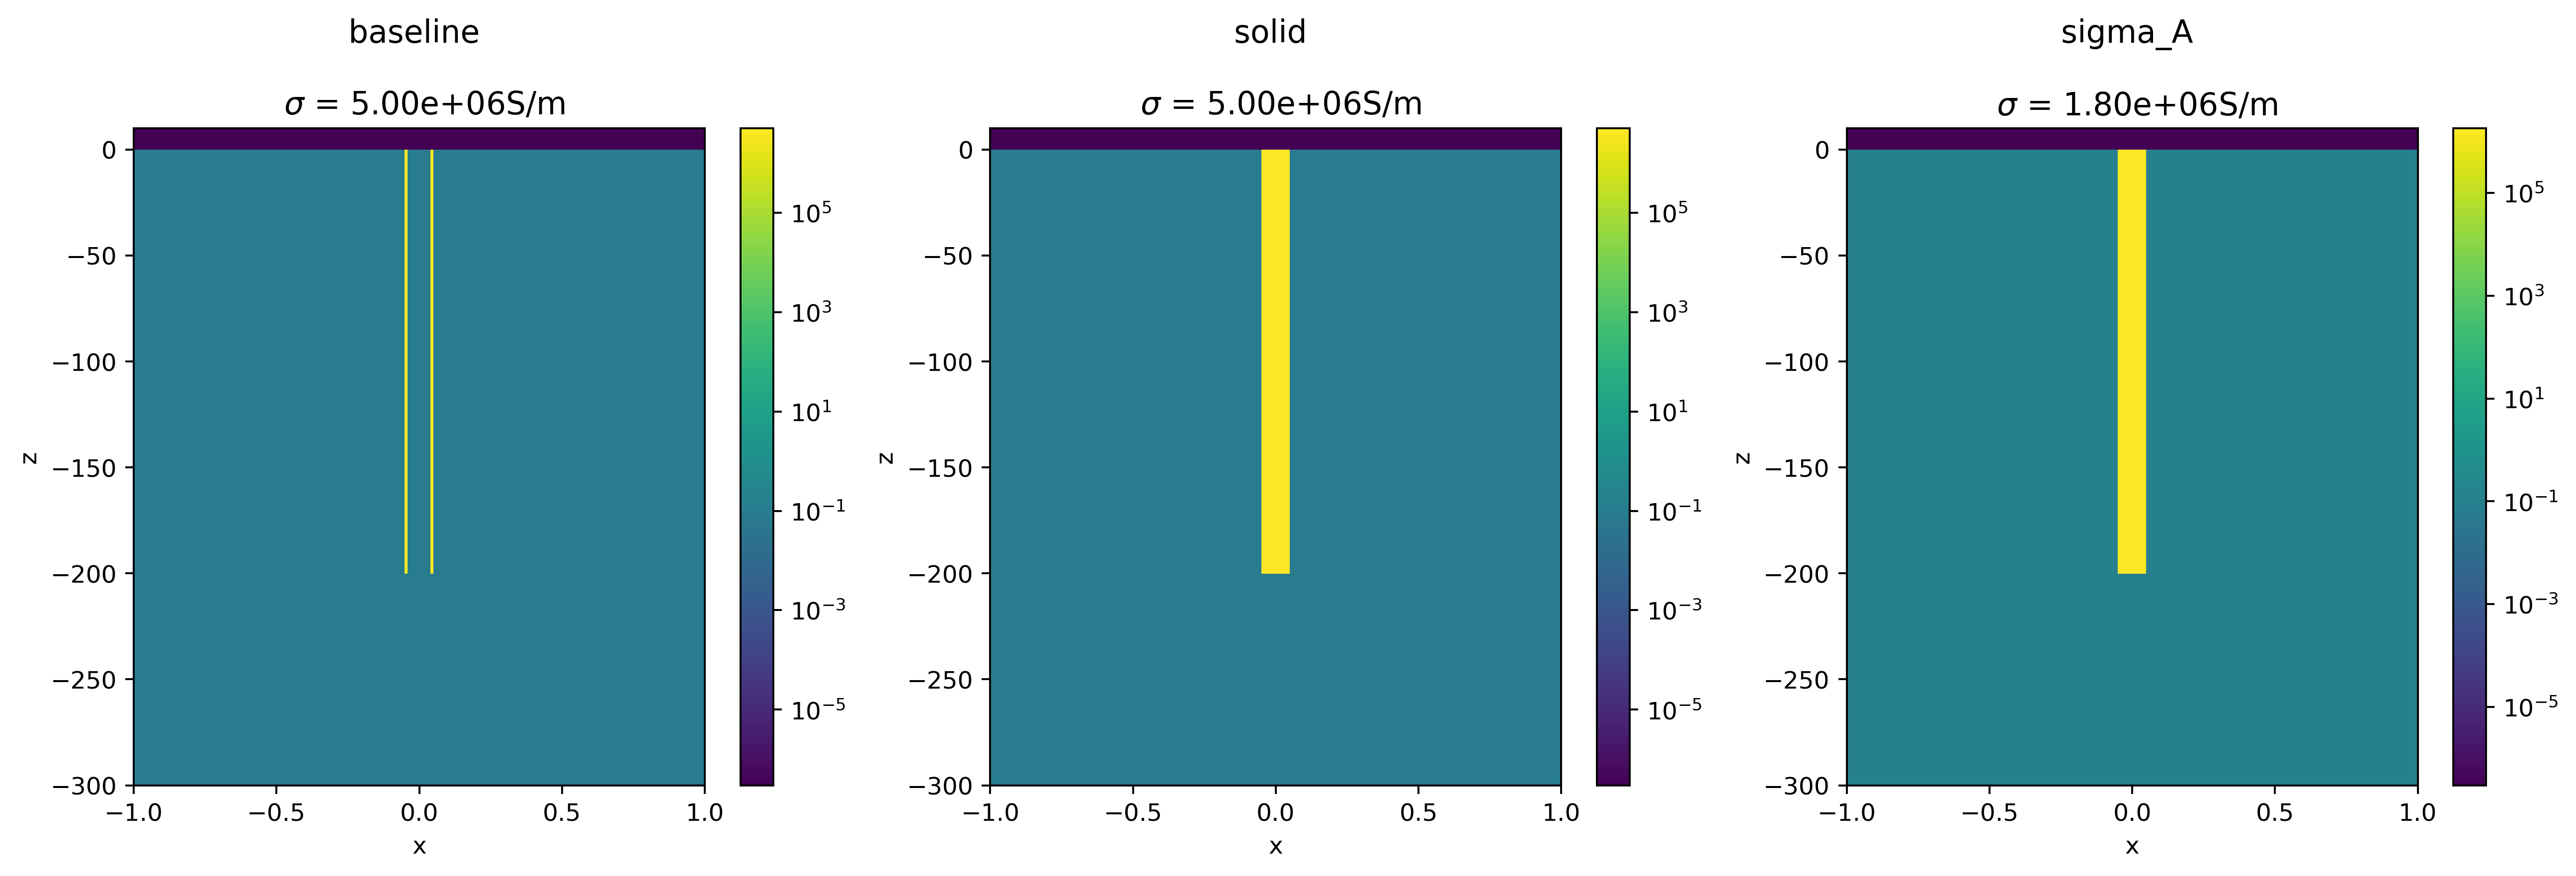

In [112]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [113]:
model.src_a

array([ 0.045     ,  3.40339204, -1.25      ])

In [114]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, np.pi, -1.25],
    [model.casing_r + 1., np.pi, -1.25],
    [model.casing_r, np.pi, -casing_l + 5.],
    [0., np.pi, -casing_l + 5.],
    [0., np.pi, -casing_l - 5.],
    [model.casing_b+cylMeshGen.csx1*2, np.pi, -casing_l + 5.]
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
    "surface, disconnected",
    "downhole",
    "downhole, disconnected",
    "below hole",
    "outside hole"
]

(-220.00000000000003, 1)

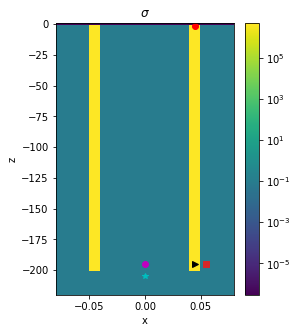

In [115]:
# Plot the source location

symbols = ['ro', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
physpropsDict['baseline'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
)

for i in range(src_a.shape[0]):
    ax.plot(src_a[i, 0], src_a[i, 2], symbols[i])
    ax.plot(src_b[i, 0], src_b[i, 2], symbols[i])
    
ax.set_xlim([-0.08, 0.08]) #src_b[:, 0].max()])
ax.set_ylim([ -1.1*model.casing_l, 1])


## set up a DC simulation

In [116]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [117]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running baseline ---
Validating parameters...
      max x: 14124.70836130856, min z: -14552.855805436326, max z: 14352.855805436318, nC: 147936
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 4.551257133483887


--- Running solid ---
Validating parameters...
      max x: 14124.70836130856, min z: -14552.855805436326, max z: 14352.855805436318, nC: 147936
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 4.6510889530181885


--- Running sigma_A ---
Validating parameters...
      max x: 14124.70836130856, min z: -14552.855805436326, max z: 14352.855805436318, nC: 147936
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 3.7347676753997803


CPU times: user 20.1 s, sys: 1.45 s, total: 21.6

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [118]:
# plot e-field on surface

epsilon = 1e-16

def plot_ex_field(theta_ind=1, src_ind=0, xmin=10, xmax=500, zloc=0):
    xlim = [xmin, xmax]
    src_baseline = simDict['baseline'].survey.srcList[src_ind]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=f[src,'e'],
            pltType='semilogy', ax=ax[0],
            theta_ind=theta_ind, xlim=xlim, 
            color_ind=i, label=key, 
            zloc=zloc
        )

        if key != 'baseline':
            f = fieldsDict[key]
            casingSim.view.plotLinesFx(
                cylMeshGen.mesh,
                field=100*(
                    np.absolute(f[src,'e'] - fieldsDict['baseline'][src_baseline,'e'])/
                    (np.absolute(fieldsDict['baseline'][src_baseline,'e']) + epsilon)
                ),
                pltType='plot', ax=ax[1],
                theta_ind=theta_ind, xlim=xlim, 
                color_ind=i, label=key, zloc=zloc
            )
    
#     print('src_a = {}'.format(src_a[src_ind, :]))
    ax[0].legend()
    ax[0].set_ylabel('Electric Field (V/m)') 
    ax[0].set_title(src_names[src_ind])

    ax[1].legend()
    ax[1].set_ylabel('percent difference')
    plt.tight_layout()
    plt.show()


In [119]:
ipywidgets.interact(
    plot_ex_field,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
    src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
    xmin = ipywidgets.FloatText(value=10), 
    xmax = ipywidgets.FloatText(value=500),
    zloc = ipywidgets.FloatText(value=0)
)

interactive(children=(IntSlider(value=1, description='theta_ind', max=11), IntSlider(value=0, description='src_ind', max=5), FloatText(value=10.0, description='xmin'), FloatText(value=500.0, description='xmax'), FloatText(value=0.0, description='zloc'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_ex_field>

## Plot the casing currents

In [120]:
# plot currents in casing

epsilon = 1e-16

def plot_casing_currents(src_ind=0):
   
    src_baseline = simDict['baseline'].survey.srcList[src_ind]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    ax = discretize.utils.mkvc(ax)

    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    currents_baseline = casingSim.physics.casing_currents(
        fieldsDict['baseline'][baseline_src, 'j'], cylMeshGen.mesh, 
        modelDict['baseline']
#         modelDict['baseline'].casing_a, 
#         0,
#         modelDict['baseline'].casing_b, modelDict['baseline'].casing_z,
    )
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        mod = modelDict[key]
        
        currents = casingSim.physics.casing_currents(
            f[src, 'j'], cylMeshGen.mesh, mod 
#             mod.casing_a if key == 'baseline' else 0, 
#             mod.casing_b, mod.casing_z,
        )
        
        ax[0].plot(currents["z"][0], -currents["z"][1], label=key, color="C{}".format(i))
#         ax[2].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))

        if key != 'baseline':
        
            ax[1].plot(
                currents["z"][0], 
                np.absolute(
                    currents["z"][1]-currents_baseline["z"][1]
                )/(
                    np.absolute(currents_baseline["z"][1])+epsilon
                )*100,
                label=key, color="C{}".format(i)
            )
#             ax[3].plot(
#                 cylMeshGen.mesh.vectorCCz, 
#                 np.absolute(ix-ix_baseline)/(np.absolute(ix_baseline)+epsilon),
#                 label=key, color="C{}".format(i)
#             )
            
    
    [a.set_xlim([0., -casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('depth (m)')]
#     ax[0].set_ylabel('Electric Field (V/m)')    

#     ax[1].legend()
#     ax[1].set_ylabel('percent difference')

    ax[0].set_ylabel('Downward-going Current (A)')
    ax[1].set_ylabel('Percent difference from baseline')
    
    ax[0].set_title(src_names[src_ind] + ' source \n\n Vertical Current in Casing')
    ax[1].set_title('Difference from baseline (%)')
    
    
    plt.tight_layout()
    plt.show()

In [121]:
ipywidgets.interact(
    plot_casing_currents, 
    src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0)
)

interactive(children=(IntSlider(value=0, description='src_ind', max=5), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_casing_currents>

In [122]:
casingSim.physics.casing_currents?

In [125]:
# plot currents in casing

epsilon = 1e-16

def plot_casing_currents_multisrc(model='baseline'):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    ax = discretize.utils.mkvc(ax)

    f = fieldsDict[model]
    mod = modelDict[model]
        
    for i, src in enumerate(simDict[model].survey.srcList):
        
        currents = casingSim.physics.casing_currents(
            f[src, 'j'], cylMeshGen.mesh, mod 
#             mod.casing_b, mod.casing_z,
        )
        
        ax[0].plot(currents["z"][0], -currents["z"][1], label=src_names[i], color="C{}".format(i))
        ax[1].plot(currents["z"][0], np.absolute(currents["z"][1]), label=src_names[i], color="C{}".format(i))
        
            
    
    [a.set_xlim([0., -casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]

    ax[0].set_ylabel('Downward-going Current (A)')
    ax[1].set_ylabel('Vertical Current Amplitude (A)')
    
    plt.tight_layout()
    plt.show()

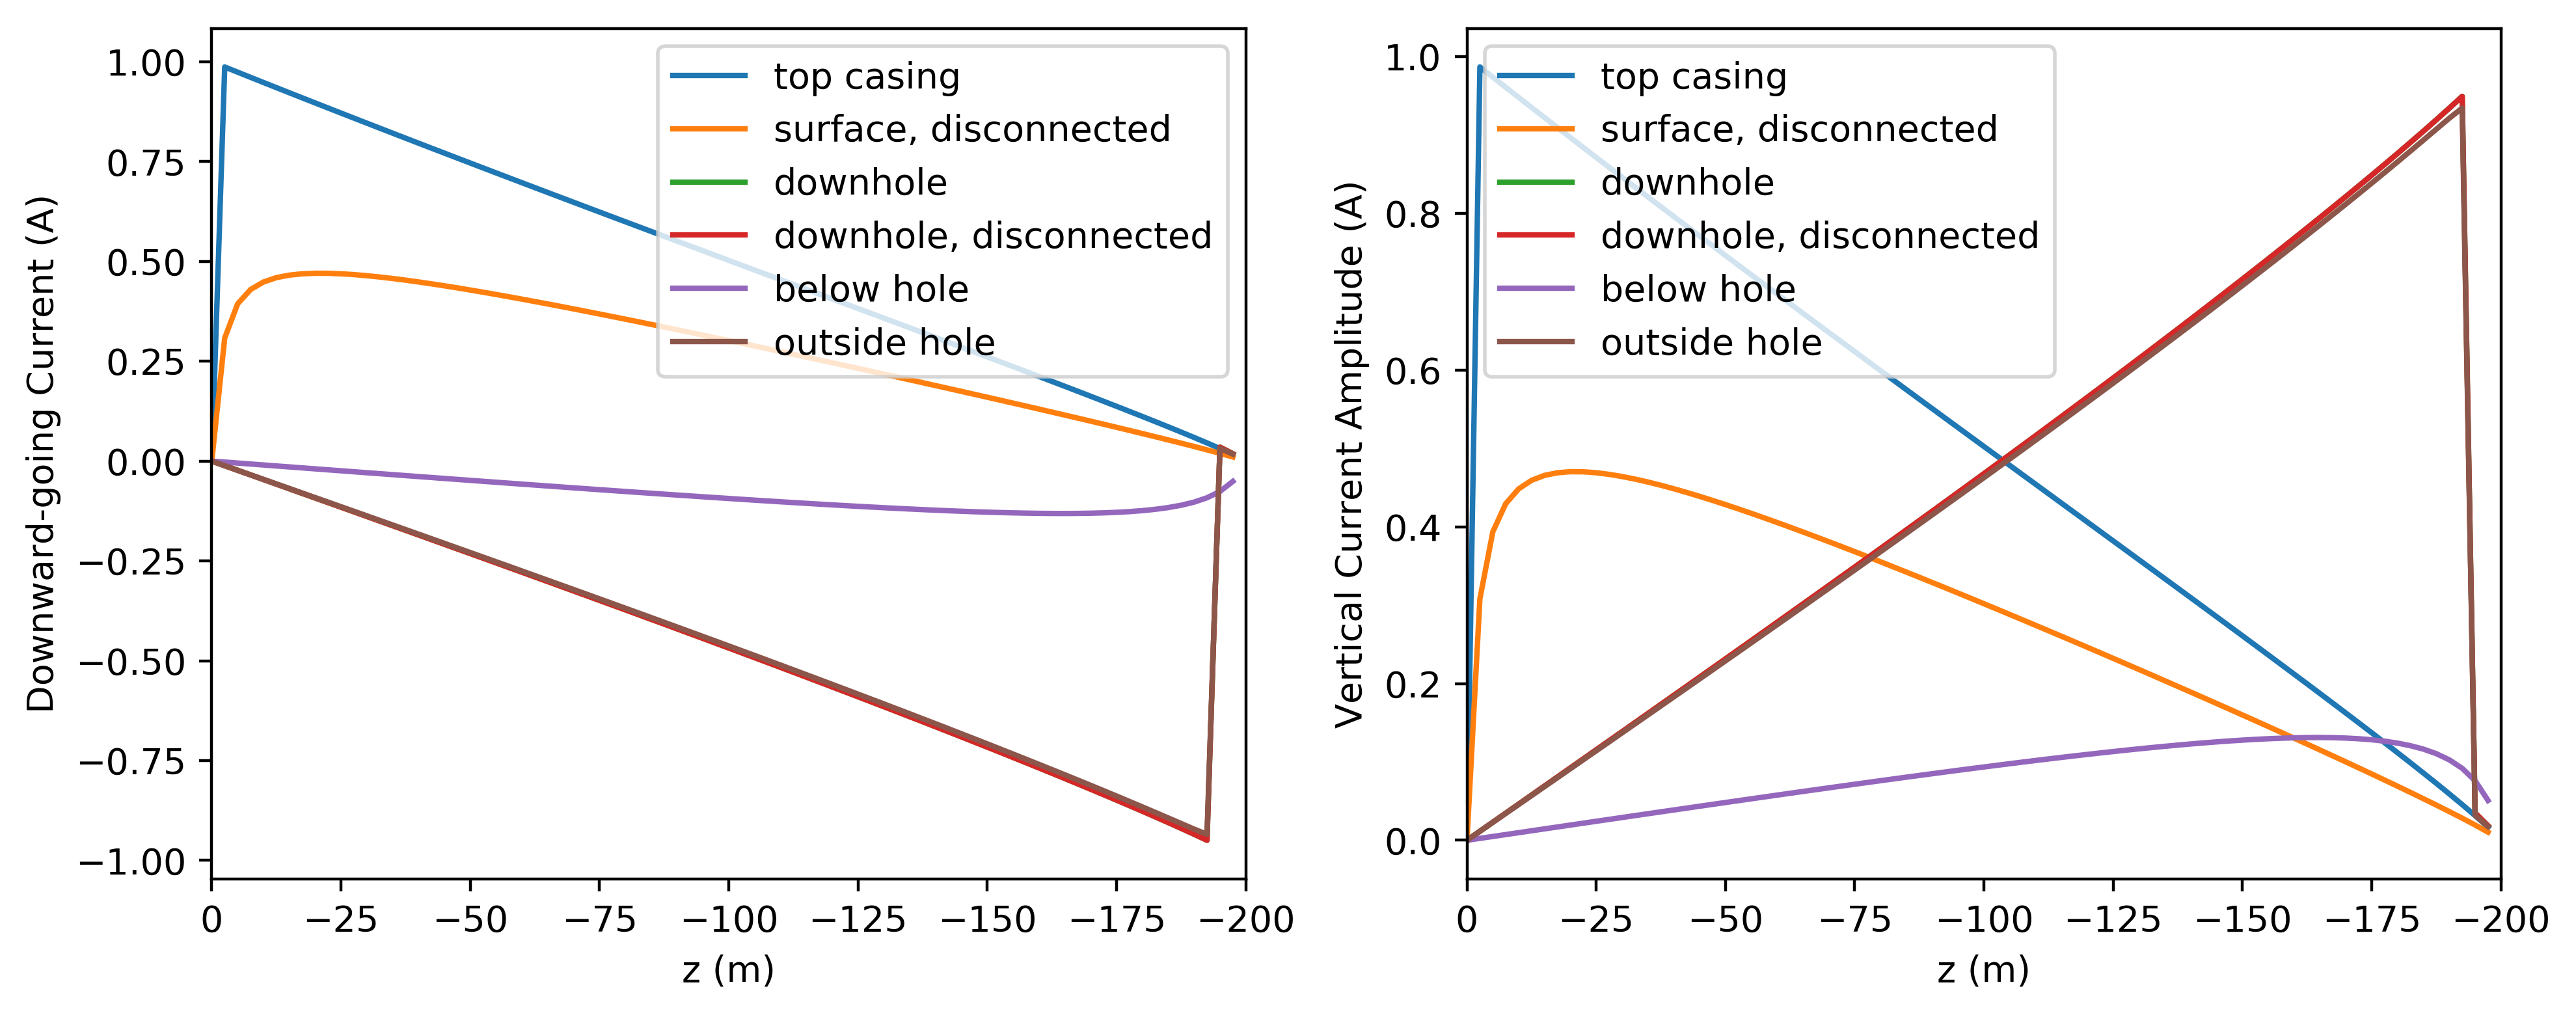

In [126]:
plot_casing_currents_multisrc()

In [127]:
def horizontal_current_flux(mesh, j, radius=1):
    Fx_inds = np.absolute(mesh.gridFx[:,0] - radius) == np.min(np.absolute(mesh.vectorNx - radius))

    jA = utils.sdiag(mesh.area) * j
    jA_surface = jA[
        np.hstack([Fx_inds, np.zeros(mesh.nFy, dtype=bool), np.zeros(mesh.nFz, dtype=bool)])
    ].reshape(mesh.vnFx[1], mesh.vnFx[2], order='F')

    ix = jA_surface.sum(0)
    
    return ix

In [128]:
# plot currents in casing

epsilon = 1e-16

def plot_formation_currents(src_ind=0, radius=1, ymax=None):
   
    src_baseline = simDict['baseline'].survey.srcList[src_ind]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    ax = discretize.utils.mkvc(ax)

    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    ix_baseline = horizontal_current_flux(
        cylMeshGen.mesh, fieldsDict['baseline'][baseline_src, 'j'], radius
    )
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        
        ix = horizontal_current_flux(
            cylMeshGen.mesh, fieldsDict[key][src, 'j'], radius
        )
        
        ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))

        if key != 'baseline':
        
            ax[1].plot(
                cylMeshGen.mesh.vectorCCz, 
                np.absolute(ix-ix_baseline)/(np.absolute(ix_baseline)+epsilon)*100,
                label=key, color="C{}".format(i)
            )
    
    [a.set_xlim([0., -1.25*casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]
    
    if not ymax is not None or ymax !=0:
        ylim = [0, ymax]
        ax[0].set_ylim(ylim)

    ax[0].set_ylabel('Horizontal currents (A)')
    ax[1].set_ylabel('Percent difference from baseline')
    
    ax[0].set_title(src_names[src_ind] + ' source \n\n Horizontal Current in Formation, r={}'.format(radius))
    ax[1].set_title('Difference from baseline (%)')
    
    
    plt.tight_layout()
    plt.show()

In [129]:
ipywidgets.interact(
    plot_formation_currents,
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_names)-1, value=0), 
    radius=ipywidgets.FloatText(value=10),
    ymax=ipywidgets.FloatText(value=0)
)

interactive(children=(IntSlider(value=0, description='src_ind', max=5), FloatText(value=10.0, description='radius'), FloatText(value=0.0, description='ymax'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_formation_currents>

In [130]:
# plot currents in casing

epsilon = 1e-16

def plot_formation_currents_multisrc(radius=100, model='baseline'):
   
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    ax = discretize.utils.mkvc(ax)
    
    f = fieldsDict[model]
    
    for i, src in enumerate(simDict[model].survey.srcList):
        
        ix = horizontal_current_flux(
            cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
        )
        
        ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
        ax[1].semilogy(cylMeshGen.mesh.vectorCCz, np.abs(ix), label=src_names[i], color="C{}".format(i))
    
    [a.set_xlim([0., -1.25*casing_l]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('z (m)') for a in ax]

    [a.set_ylabel('Horizontal currents (A)') for a in ax]
    
    ax[0].set_title('Horizontal Current in Formation, r={}'.format(radius))
#     ax[1].set_title('')
    
    ax[1].set_ylim([1e-4, 2e-1])
    plt.tight_layout()
    plt.show()
    
    return ax

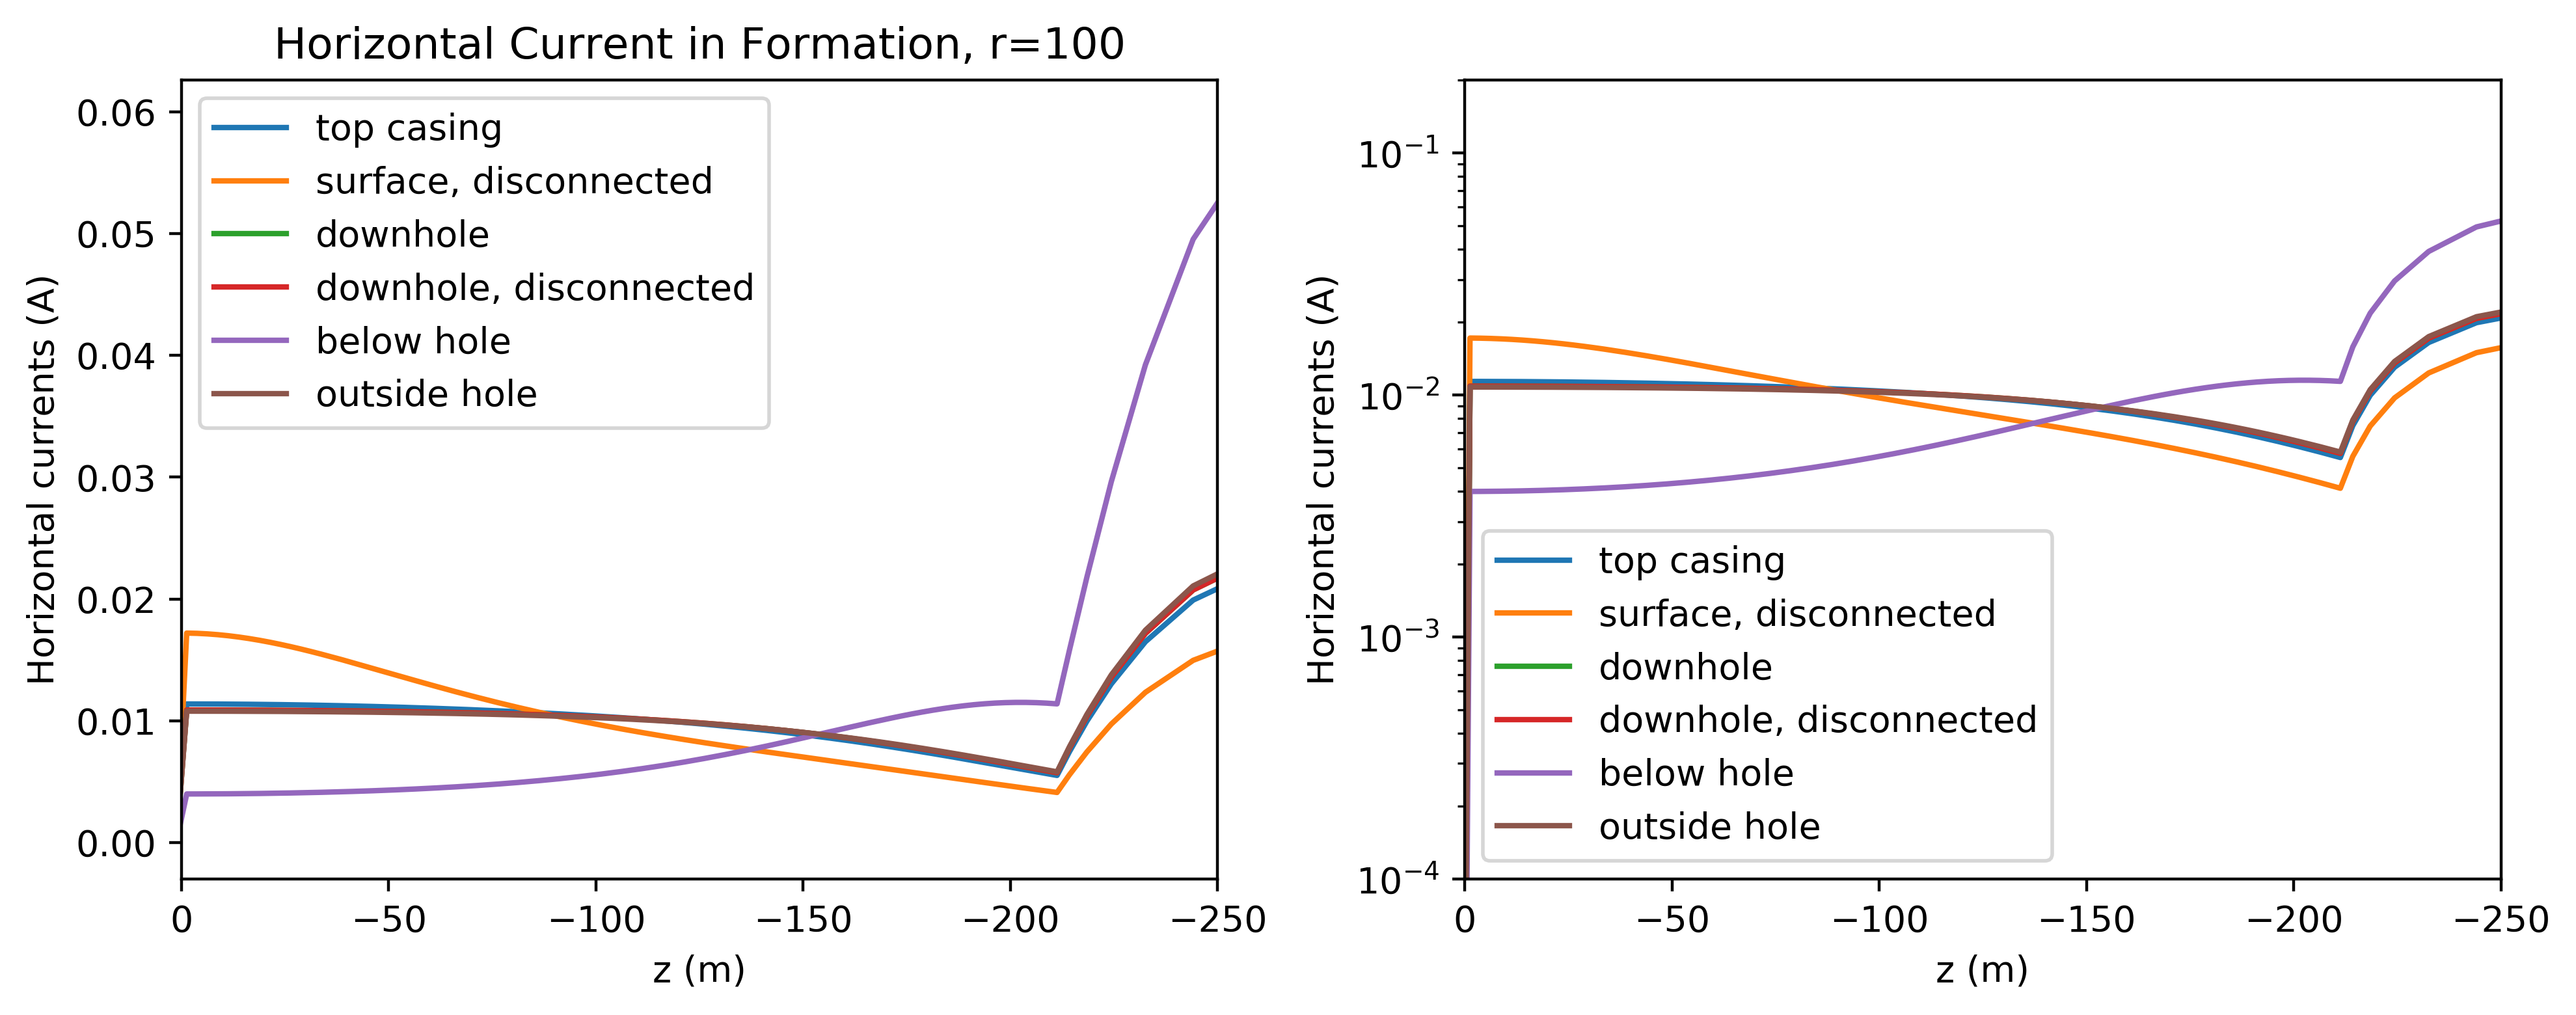

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1811933a90>,
      dtype=object)

In [131]:
plot_formation_currents_multisrc()

## Charges

How do the charges change with different casing models?

In [132]:
# Plot the charges
mesh2D = cylMeshGen.create_2D_mesh().mesh

def plotScalar(
    theta_ind=0, src_ind=0, clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='all'
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    
    assert view.lower() in ['charge', 'phi', 'j']

    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
            
    if len(model_names) == 1:
        ax = [ax] 
        
    for a, title in zip(ax, model_names):
        pp = physpropsDict[title]
        src = simDict[title].survey.srcList[src_ind]
        plotme = simDict[title].fields()[src, view]
        
        if view in ['charge', 'phi']:
            _, cb = pp.plot_prop(
                plotme,
                ax=a,
                pcolorOpts = {'cmap': 'bwr' if view == 'charge' else 'viridis'},
                **plotopts
            )
        elif view == 'j':
            jplt = casingSim.face3DthetaSlice(
                cylMeshGen.mesh, plotme, theta_ind=theta_ind
            )
            
            _, cb = casingSim.plotFace2D(
                mesh2D,
                jplt, real_or_imag='real', ax=a, range_x=xlim,
                range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
                logScale=True, clim=clim
            )
        a.set_title('{} source \n {} model \n\n $\sigma$ = {:1.2e}S/m, \ntheta = {:1.1f} degrees'.format(
            src_names[src_ind], title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)
#         cb.set_label(view)
        
        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k', 
            lw = 0.5
        )
    plt.tight_layout()
    plt.show()

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

interactive(children=(IntSlider(value=1, description='theta_ind', max=11), IntSlider(value=0, description='src_ind', max=5), FloatText(value=0.0, description='clim_max'), FloatText(value=0.0, description='clim_min'), FloatText(value=250.0, description='max_depth'), FloatText(value=0.1, description='max_r'), FloatText(value=10.0, description='top'), ToggleButtons(description='view', options=('charge', 'phi', 'j'), value='charge'), ToggleButtons(description='model', options=('baseline', 'solid', 'sigma_A', 'all'), value='baseline'), Output()), _dom_classes=('widget-interact',))

<function __main__.plotScalar>

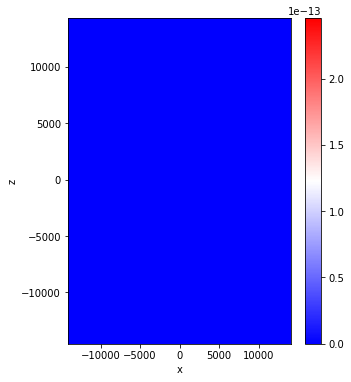

In [133]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotScalar,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
    src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=np.ceil(1.25*model.casing_l)), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(
        options=['charge', 'phi', 'j'], value='charge'
    ),
    model = ipywidgets.ToggleButtons(
        options=['baseline', 'solid', 'sigma_A', 'all'], value='baseline'
    )
)   

In [134]:
# Plot the models

def plotScalarDifference(
    clim_max=None, theta_ind=0, src_ind=0, max_depth=1.1*model.casing_l, max_r=0.1, top=10.,  view='charge', 
):
    assert view in ['charge', 'phi']
        
    fig, ax = plt.subplots(1, len(model_names)-1, figsize=(5*(len(model_names)-1), 5))
    
    xlim = max_r*np.r_[0, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    src_baseline = simDict['baseline'].survey.srcList[src_ind]
    
    for a, title in zip(ax, ['solid', 'sigma_A']):
        pp = physpropsDict[title]
        src = simDict[title].survey.srcList[src_ind]
        plotme = simDict[title].fields()[src, view] - simDict['baseline'].fields()[src_baseline, view]
        
        if clim_max is None or clim_max == 0.:
            clim = np.absolute(plotme).max() * np.r_[-1., 1.]
        else: 
            clim = clim_max * np.r_[-1, 1]
        
        _, cb = pp.plot_prop(
            plotme,
            ax=a,
            pcolorOpts={
                'cmap': 'bwr' if view == 'charge' else 'viridis',
            },
            clim=clim,
            theta_ind=theta_ind
        )
        a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m\ntheta = {:1.2f} degree'.format(
            title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
        ), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
        a.set_xlim(xlim)
        a.set_ylim(zlim)
        cb.set_label('secondary ' + view)
        
        # plot outline of casing
        m = modelDict[title]
        a.plot(
            np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
            np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
            'k' if view == 'charge' else 'w', 
            lw = 0.5
        )
    
    plt.tight_layout()
    plt.show()

### Plot the difference in charge distributions (approximation - true) 

observations: 
- first: colorbar scales are different between the two! 
- solid steel: more negative at top, positive at bottom (consistent with more uniform charge distribution) 

interactive(children=(FloatText(value=0.0, description='clim_max'), IntSlider(value=1, description='theta_ind', max=11), IntSlider(value=0, description='src_ind', max=5), FloatText(value=250.0, description='max_depth'), FloatText(value=0.1, description='max_r'), FloatText(value=10.0, description='top'), ToggleButtons(description='view', options=('charge', 'phi'), value='charge'), Output()), _dom_classes=('widget-interact',))

<function __main__.plotScalarDifference>

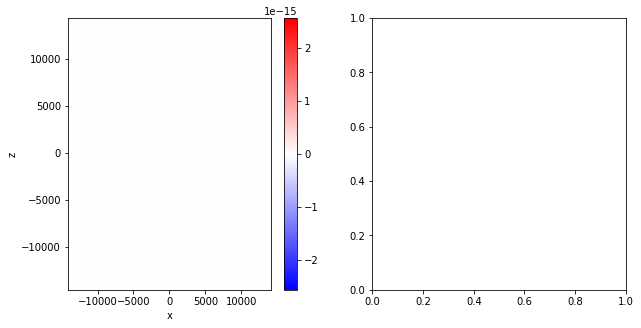

In [135]:
ipywidgets.interact(
    plotScalarDifference,
    theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
    src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
    clim_max = ipywidgets.FloatText(value=0), 
    max_depth = ipywidgets.FloatText(value=1.25*model.casing_l), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(options=['charge', 'phi'], value='charge'), 
)

### Total charge on the casing

- integrate the charge on the casing. 

In [ ]:
for src_ind in range(src_a.shape[0]):
    print('\n----- src {} ------'.format(src_a[src_ind,[0,2]]))
    casing_charge = {}
    for title in model_names:
        casing_charge[title] = (
            utils.mkvc(simDict[title].fields()[simDict[title].survey.srcList[src_ind], 'charge'])
        )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
        print('{:8s}: {:1.3e}'.format(title, casing_charge[title]))

In [ ]:
print(np.finfo(float).eps)